# README

using jin2019, rerun

# import

In [1]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
import pickle
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm

import scipy.io as sio
import scipy.stats as stats
from scipy.stats import ttest_rel
import scikit_posthocs as sp

import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1 # x and y axis thick
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
## plot setting for paper

# cm_to_in = 1/2.54  # centimeters in inches
# scale = 1
# fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

# linewidth=1
# fontsize=8
# plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
# plt.tick_params(direction='out', length=3, width=1)

# plt.xlabel('x', fontsize=9, labelpad=2)
# plt.ylabel('y', fontsize=9, labelpad=1, loc='top')

# ax.spines['left'].set_linewidth(1) # set axis width
# ax.spines['bottom'].set_linewidth(1)

# metadata

In [3]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter/'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [7]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
meta = data_info[(data_info.paradigm == 'grating_lindsey_miaomiao')].reset_index(drop=True)
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,time,AWS,note
0,674,170324,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN,TC and input already concat-ed 002-003. see in...
1,689,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN,NaN
2,696,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN,NaN
3,684,170327,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN,NaN
4,711,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN,NaN
5,712,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN,NaN
6,574,170510,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN,NaN
7,720,170808,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN,NaN
8,738,170810,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN,NaN
9,739,170811,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN,NaN


# batch write df_tidy 
(don't rerun unless needed)

In [8]:
# nset = len(meta)

# for iset in tqdm(range(nset)):
#     print(f'iset={iset}, nset={nset}')


#     ## load data
#     mouse = meta.loc[iset, 'mouse'].astype(str)
#     imouse = 'i' + mouse
#     date = meta.loc[iset, 'date'].astype(str)
#     area = meta.loc[iset, 'area']
#     sess = meta.loc[iset, 'num']
#     print(mouse, date, area, sess)
#     dir_identifier = f'{area}_{imouse}_{date}_{sess}'

#     mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
#     for dirname in os.listdir(mat_inter):
#         if dir_identifier in dirname:
#             dir_data = mat_inter + dirname
#             break

#     stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
#     ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


#     ## construct dfof
#     R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
#     R2_dfof = resp_tg.flatten()
#     dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


#     ## construct cell, trial, resp id
#     ncell = resp_ad.shape[0]
#     ntrial = resp_ad.shape[1]
#     cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
#     cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

#     trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
#     trial_id = np.hstack((trial_id, trial_id))

#     len_df = ncell * ntrial * 2 # 2 for (R1, R2)
#     resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


#     ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
#     trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
#     trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
#     for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#         trial_stim_orien_dict[item] = i
#     trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

#     trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
#     trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

#     trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
#     trial_isi_nframe = trial_isi_nframe[:ntrial]
#     trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

#     ## make stim info col: same as trial_id - tile then hstack
#     stim_id_col = np.tile(trial_stim_orien_int, ncell)
#     isi_col = np.tile(trial_isi_nframe, ncell)
#     ad_con_col = np.tile(trial_adapter_contrast, ncell)

#     stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
#     isi_col = np.hstack((isi_col, isi_col))
#     ad_con_col = np.hstack((ad_con_col, ad_con_col))

#     df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                             'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                             'stim2_id': stim_id_col,})
#     df_tidy['area'] = area
#     df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
#     df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
#     df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

#     df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
#     df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


#     ## vis cell filter, well_fit filter, & img driven cell-stim filter
#     df_tidy['filter_cell_vis'] = np.nan
#     df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
#     df_tidy['filter_cell_well_fit'] = np.nan
#     df_tidy['filter_cell_stim'] = np.nan

#     with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # changed to strict bonferroni
#     # with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni_strict.pickle'), 'rb') as f: # changed to strict bonferroni
#         filter_file = pickle.load(f)
#     filter_cell_stim = filter_file['img_driven']
#     filter_cell_vis = filter_file['vis_driven']
#     filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim
        
#     well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
#     well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

#     for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#         for istim in np.arange(filter_cell_stim.shape[1]):
#             df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]

#     ## save df_tidy as csv
#     df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

# # clear_output()

  0%|          | 0/12 [00:00<?, ?it/s]

iset=0, nset=12
674 170324 V1 002-003
ncell: 73, nstim: 8, ntrial: 437


  8%|▊         | 1/12 [00:02<00:22,  2.03s/it]

iset=1, nset=12
689 170323 V1 002-003
ncell: 19, nstim: 8, ntrial: 437


 17%|█▋        | 2/12 [00:02<00:11,  1.19s/it]

iset=2, nset=12
696 170323 V1 002-003
ncell: 73, nstim: 8, ntrial: 394


 25%|██▌       | 3/12 [00:04<00:12,  1.43s/it]

iset=3, nset=12
684 170327 V1 002-003
ncell: 31, nstim: 8, ntrial: 386


 33%|███▎      | 4/12 [00:05<00:09,  1.24s/it]

iset=4, nset=12
711 170503 V1 002-003
ncell: 33, nstim: 8, ntrial: 436


 42%|████▏     | 5/12 [00:06<00:08,  1.19s/it]

iset=5, nset=12
712 170503 V1 002-003
ncell: 43, nstim: 8, ntrial: 437


 50%|█████     | 6/12 [00:07<00:07,  1.25s/it]

iset=6, nset=12
574 170510 V1 002-003
ncell: 94, nstim: 8, ntrial: 336


 58%|█████▊    | 7/12 [00:09<00:07,  1.57s/it]

iset=7, nset=12
720 170808 V1 002-003
ncell: 55, nstim: 8, ntrial: 436


 67%|██████▋   | 8/12 [00:11<00:06,  1.62s/it]

iset=8, nset=12
738 170810 V1 002-003
ncell: 16, nstim: 8, ntrial: 396


 75%|███████▌  | 9/12 [00:12<00:03,  1.30s/it]

iset=9, nset=12
739 170811 V1 002-003
ncell: 35, nstim: 8, ntrial: 436


 83%|████████▎ | 10/12 [00:13<00:02,  1.27s/it]

iset=10, nset=12
745 170816 V1 002-003
ncell: 66, nstim: 8, ntrial: 437


 92%|█████████▏| 11/12 [00:15<00:01,  1.39s/it]

iset=11, nset=12
746 170826 V1 002-003
ncell: 49, nstim: 8, ntrial: 436


100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


# batch load df tidy

In [18]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)): # 1 min for 7 + 22 + 18 (V1 + LM + LI)

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']

    dir_identifier = f'{area}_{imouse}_{date}_{sess}'
    if sess == 'multisess':
        dir_identifier = f'{area}_{imouse}_{date}' # multisess data folder has no sess number

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.mouse.astype(str) + '_' 
                               + df_tidy_now.date.astype(str) + '_' 
                            #    + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    
clear_output()
df_tidy['mousedate'] = df_tidy.mouse.astype(str) + '_' + df_tidy.date.astype(str)

In [19]:
df_tidy.mousedate.unique()

array(['674_170324', '689_170323', '696_170323', '684_170327',
       '711_170503', '712_170503', '574_170510', '720_170808',
       '738_170810', '739_170811', '745_170816', '746_170826'],
      dtype=object)

## filter_cell_vis_strict
based on pval

In [20]:
p_sig = 0.05
nstim = 8 # 8 ori

df_tidy['filter_cell_vis_strict'] = df_tidy['filter_cell_vis_pval'] < p_sig / nstim # bonferroni corrected
df_tidy.groupby('cell_id').head(1).groupby('area').filter_cell_vis_strict.value_counts()

area  filter_cell_vis_strict
V1    False                     335
      True                      252
Name: count, dtype: int64

# find wellmax & tuning bias
don't rerun, skip to section end to read_csv

## filter cell well-max 
no rerun to prevent pd.merge duplicate col

In [21]:
## construct tuning_vec column
max_ori_bootstrap = np.array([])
nboot = 50
for iboot in tqdm(range(nboot)):
    max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .sample(frac=.7, random_state=iboot) # sample x trials per group. min rep = 48
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
                .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
                .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
                .rename(columns={0: 'max_ori'}).max_ori.values
                )
    max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)
max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

## sort max_ori_bootstrap in each col (across boots)
max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

## count the most freq value in each col (across boots)
max_ori_mode_freq = stats.mode(max_ori_bootstrap, axis=0)[1] # count of mode (freq of most freq max_ori)
filter_cell_well_max = (max_ori_mode_freq >= nboot * 0.7) # NOTE: strictness of well-max can be adjusted here
filter_cell_well_max_cont = max_ori_mode_freq / nboot # continuous measure of well-max

## merge filter_cell_well_max with df
df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
                .groupby(['cell_id', 'isi'])
                .first() # get first trial per cell, isi
                .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
                )
df_well_max['filter_cell_well_max'] = filter_cell_well_max
df_well_max['filter_cell_well_max_cont'] = filter_cell_well_max_cont

df_tidy = df_tidy.merge(df_well_max, 
      on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi

100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


In [23]:
pd.options.mode.chained_assignment = None  # default='warn', suppress SettingWithCopyWarning

df_well_max = df_tidy[(df_tidy.isi == 6000) & (df_tidy.sess != 'multisess')] # determine well max cell in ISI=6k, write for single sess data
# df_well_max['date_sess'] = df_well_max.date.astype(str) + '_' + df_well_max.sess.astype(str)

for mousedate in tqdm(df_well_max.mousedate.unique()):
    df_well_max_sess = df_well_max[df_well_max.mousedate == mousedate]
    df_well_max_sess = df_well_max_sess[['mousedate', 'cell_id', 
                                         'filter_cell_well_max', 
                                         'filter_cell_well_max_cont']]
    df_well_max_sess['cell_id_int'] = df_well_max_sess.cell_id.str.split('_').apply(lambda x: int(x[-1])) # cast cell_id from str to int
    df_well_max_sess = df_well_max_sess.groupby('cell_id_int').first().reset_index() # groupby sorts cell_id
    ncell_keep = '' # keep all wellmax cell
    well_max_sess = df_well_max_sess.filter_cell_well_max.values.astype(float) # well max cell filter in this session. must cast to float for matlab to index with bool

    # ## redefine well_max_sess: boolean of whether this cell is among the 10 largest filter_cell_well_max_cont
    # ncell_keep = 20
    # well_max_id = df_well_max_sess.sort_values('filter_cell_well_max_cont', ascending=False).head(ncell_keep).cell_id_int.values
    # well_max_sess = np.zeros_like(df_well_max_sess.filter_cell_well_max_cont.values)
    # well_max_sess[well_max_id] = 1

    ## find session subdir in mat_inter
    mat_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if date_sess in dirname: # this accounts for cellpose vs manual segm
            dir_sess = mat_inter + '/' + dirname
            break
    
    ## save well max .mat
    sio.savemat(os.path.join(dir_sess, f'well_max_{ncell_keep}cell.mat'), {'well_max': well_max_sess})

100%|██████████| 12/12 [00:00<00:00, 33.28it/s]


In [24]:
# df_wellmax_bycell = df_well_max.groupby('cell_id').first().reset_index()
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# df_wellmax_bycell.to_csv(os.path.join(dir_data, 'df_wellmax_bycell_jin2019.csv'), index=False)
df_wellmax_bycell = pd.read_csv(os.path.join(dir_data, 'df_wellmax_bycell_jin2019.csv'))
df_wellmax_bycell.head(2)

,cell_id,dfof,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_vis_pval,filter_cell_well_fit,filter_cell_stim,mouse,date,sess,mousedate,filter_cell_vis_strict,filter_cell_well_max,filter_cell_well_max_cont
0,574_170510_0,0.131212,0,R2,6000,0,0,V1,0,True,2.638220e-03,1.0,True,574,170510,002-003,574_170510,True,False,0.64
1,574_170510_1,0.418686,0,R2,6000,0,0,V1,0,True,6.565043e-08,1.0,False,574,170510,002-003,574_170510,True,False,0.52


## tuning pref & tuning bias
(no rerun)
crude preference: take max-resp orientation as the preferred orien

In [25]:
pref_ori_noad = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_noad'})
                )

pref_ori_ad_250 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)]
                .groupby(['cell_id', 'stim2_id'])
                [['dfof']].sum().reset_index()
                .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
                ['dfof'].apply(list).to_frame()
                .dfof.apply(lambda x: np.argmax(x)).to_frame()
                .rename(columns={'dfof': 'pref_ori_ad_250'})
                )

# pref_ori_ad_750 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 750)]
#                 .groupby(['cell_id', 'stim2_id'])
#                 [['dfof']].sum().reset_index()
#                 .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
#                 ['dfof'].apply(list).to_frame()
#                 .dfof.apply(lambda x: np.argmax(x)).to_frame()
#                 .rename(columns={'dfof': 'pref_ori_ad_750'})
#                 )

df_tidy = (df_tidy.merge(pref_ori_noad, on='cell_id')
            .merge(pref_ori_ad_250, on='cell_id')
            # .merge(pref_ori_ad_750, on='cell_id') # dont merge pref_ori_ad_750, to accommodate for multisess 8 ori 2 isi data
            )

In [26]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def distace_from_adapter(x):
    # adapter is always 0 deg
    x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
# df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.head()

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,mousedate,filter_cell_vis_strict,filter_cell_well_max,filter_cell_well_max_cont,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
0,0.123997,674_170324_0,0,R1,750,1,5,V1,0,True,...,674_170324,True,True,0.7,4,4,90.0,90,NaN,NaN
1,-0.020478,674_170324_0,1,R1,250,1,3,V1,0,True,...,674_170324,True,False,0.6,4,4,90.0,90,90.0,0.0
2,0.036473,674_170324_0,6,R1,250,1,5,V1,0,True,...,674_170324,True,False,0.6,4,4,90.0,90,90.0,0.0
3,-0.021505,674_170324_0,7,R1,750,1,3,V1,0,True,...,674_170324,True,True,0.7,4,4,90.0,90,NaN,NaN
4,0.018712,674_170324_0,9,R1,250,1,0,V1,0,True,...,674_170324,True,False,0.6,4,4,90.0,90,90.0,0.0


## tuning curve

In [27]:
df_tuning = df_tidy.copy()
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values # groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.head(5) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 587/587 [01:07<00:00,  8.67it/s]


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_max,filter_cell_well_max_cont,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
1,-0.020478,674_170324_0,1,R1,250,1,3,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."
2,0.036473,674_170324_0,6,R1,250,1,5,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."
4,0.018712,674_170324_0,9,R1,250,1,0,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."
5,0.094969,674_170324_0,10,R1,250,1,5,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."
6,0.043600,674_170324_0,11,R1,250,1,1,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."


# load df_tuning 

In [28]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_jin2019.csv'
# df_tuning.to_csv(os.path.join(dir_data, csv_filename), index=False)
df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

clear_output() # clear dtypewarning
df_tuning.head(2)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_max,filter_cell_well_max_cont,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
1,-0.020478,674_170324_0,1,R1,250,1,3,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."
2,0.036473,674_170324_0,6,R1,250,1,5,V1,0,True,...,False,0.6,4,4,90.0,90,90.0,0.0,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ..."


In [29]:
## fix tuning_noad column in saved csv: convert from str (fake list) to list of float
if df_tuning['tuning_noad'].values[0].__class__ == str:
    df_tuning['tuning_noad'] = df_tuning['tuning_noad'].apply(lambda x: x.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' '))
    df_tuning['tuning_noad'] = df_tuning['tuning_noad'].apply(lambda x: [float(i) for i in x if i != ''])
    df_tuning['tuning_250'] = df_tuning['tuning_250'].apply(lambda x: x.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' '))
    df_tuning['tuning_250'] = df_tuning['tuning_250'].apply(lambda x: [float(i) for i in x if i != ''])

# fig2b: R1 ori=pref across area

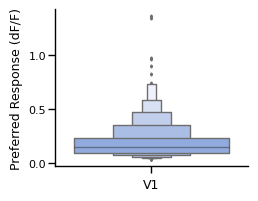

In [34]:
def R1_pref_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad) & (df_filter.resp_id == 'R2') & (df_filter.isi == 6000)].groupby(['area', 'cell_id']).dfof.mean().values # avg over rep trials, where stim2_id of this trial == pref_ori_noad of this cell, isi == 6000 (no adapter), get R2

    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.033)) 
                ] # NOTE: use the same cell filter as func adp_in_area
    return gb_R1


df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]
gb_R1_pref_V1 = R1_pref_in_area(df_filter[df_filter.area == 'V1'])
# gb_R1_pref_LM = R1_pref_in_area(df_filter[df_filter.area == 'LM'])
# gb_R1_pref_LI = R1_pref_in_area(df_filter[df_filter.area == 'LI'])


cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_pref_V1], # gb_R1_pref_LM, gb_R1_pref_LI], 
                palette=['#85A7EB'], # '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

plt.xticks([0,], ['V1',], fontsize=9);
plt.ylabel('Preferred Response (dF/F)', fontsize=9);
plt.yticks(fontsize=8);

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();
# # plt.savefig(os.path.join(dir_fig, 'fig2_R1_pref_by_area_addV1multisess.svg'))

# fig2c: R1 SNR ori=pref across area

In [35]:
def SNR_R1_ori_pref_in_area(df_filter):

    gb_R1_avg = (df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad) # stim2_id of this trial == pref_ori_noad of this cell
                       & (df_filter.resp_id == 'R2')
                       & (df_filter.isi == 6000)] # R2 but no adapter
                       .groupby(['cell_id'])
                       .dfof.mean().values) # avg over rep trials
    
    gb_R1_std = (df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad)
                       & (df_filter.resp_id == 'R2')
                       & (df_filter.isi == 6000)]
                       .groupby(['cell_id'])
                       .dfof.std().values) # std over rep trials
    
    # gb_R1_std = gb_R1_std[(np.abs(gb_R1_avg >= 0.01))] # filter std by avg first, to avoid avg changing due to filtering avg by itself
    # gb_R1_avg = gb_R1_avg[(np.abs(gb_R1_avg >= 0.01))] # NOTE: use the same cell filter in R1 and adp across areas
    gb_R1_snr = gb_R1_avg / gb_R1_std
    gb_R1_snr = gb_R1_snr[gb_R1_snr <= 4]

    return gb_R1_snr


df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]
gb_R1_pref_snr_V1 = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'V1'])
# gb_R1_pref_snr_LM = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'LM'])
# gb_R1_pref_snr_LI = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'LI'])

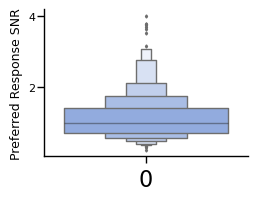

In [36]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_pref_snr_V1], # , gb_R1_pref_snr_LM, gb_R1_pref_snr_LI],
                palette=['#85A7EB'], # , '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

# plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Preferred Response SNR', fontsize=9);
plt.yticks(fontsize=8);
# yticks = ax.yaxis.get_major_ticks()
# yticks = [float(item.label.get_text()) for item in yticks]
# ax.set_yticklabels(yticks, fontsize=8)

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1pref_SNR_by_area_addV1multisess.svg'))

# fig2a: vis cell % stacked histogram


In [37]:
df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['vis_str'] = 'p>=0.05'

nstim = df_tidy.stim2_id.nunique()
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = '0.01<=p<0.05' # bonferroni correction
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.01 / nstim, 'vis_str'] = 'p<0.01'

df_vis_hist = df_cell_property.groupby('area').vis_str.value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI
df_vis_hist = df_vis_hist.iloc[:, [2, 0, 1]] # column order: not visually driven -> moderately -> strongly visually driven

df_vis_hist['ncell_total'] = df_vis_hist.sum(axis=1)
print(df_vis_hist)
for col in df_vis_hist.columns[:-1]: # normalize by total cell number in each area
    df_vis_hist[col] = df_vis_hist[col] / df_vis_hist.ncell_total * 100 # convert to percentage
df_vis_hist = df_vis_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
print(df_vis_hist)

vis_str  p>=0.05  0.01<=p<0.05  p<0.01  ncell_total
area                                               
V1           335            62     190          587
vis_str    p>=0.05  0.01<=p<0.05     p<0.01
area                                       
V1       57.069847     10.562181  32.367973


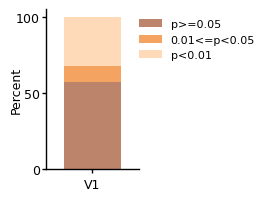

In [40]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2

ax = (df_vis_hist
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["darkred", "indianred", "lightcoral"]), 
        colormap=ListedColormap(["sienna", "sandybrown", "peachpuff"]), 
        width=0.8) # make bar thinner
        );

## set alpha for darkest color
alpha = 0.7
plt.gca().patches[0].set_alpha(alpha)
# plt.gca().patches[1].set_alpha(alpha)
# plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks(fontsize=9); # rotate x tick labels back to horizontal
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Percent', fontsize=9, labelpad=-5);
plt.legend(frameon=False, bbox_to_anchor=(0.9, 1), fontsize=8);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'vis_cell_by_area_addV1multisess.svg'))

# fig3a: grand avg trace across areas

In [41]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')


def trace_longer_baseline(trace_by_trial, tail_frame_start=180, nframe_plot=90):

    ncell = trace_by_trial.shape[0]
    ntrial = trace_by_trial.shape[1]

    trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
    trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
    trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]

    trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
    trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

    return trace_by_trial_reorder


def trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=180):
    df_fig2 = df_tidy.copy() # df_tidy comes from section "load df tidy"
    df_fig2 = df_fig2[(df_fig2.area == select_area)
                    & (df_fig2.isi == 250) & (df_fig2.stim2_id == 0)
                    & (df_fig2.resp_id == 'R2')
                    & (df_fig2.filter_cell_vis == True)
                    # & (df_fig2.filter_cell_vis_strict == True)
                    ]

    trace_by_cell_concat = np.array([])
    for mousedate in tqdm(df_fig2.mousedate.unique()):
        
        df_now = df_fig2[df_fig2.mousedate == mousedate]
        area_imouse_date_sess = (df_now.area.unique()[0] 
                                + '_i' + df_now.mouse.unique()[0] 
                                + '_' + df_now.date.unique()[0]
                                + '_' + df_now.sess.unique()[0]
                                )
        # area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
        dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
        trace = sio.loadmat(dir_sess_trace)
        trace_by_trial = trace['trace_by_trial']
        trace_by_trial = trace_longer_baseline(trace_by_trial, tail_frame_start=tail_frame_start)

        cell_id = df_now.cell_id.unique()
        cell_id = [item.split('_')[-1] for item in cell_id]
        cell_id = [int(item) for item in cell_id]
        trial_id = df_now.trial_id.unique()

        nframe_keep = 200
        trace_filtered = trace_by_trial[cell_id, :, :nframe_keep]
        trace_filtered = trace_filtered[:, trial_id, :nframe_keep]
        trace_by_cell = np.mean(trace_filtered, axis=1) # ncell x nframe, avg across trials of isi=250, ori=0
        
        if trace_by_cell_concat.size == 0:
            trace_by_cell_concat = trace_by_cell
        else: ## stack trace_by_cell onto trace_by_cell_concat
            trace_by_cell_concat = np.vstack([trace_by_cell_concat, trace_by_cell])

    print(trace_by_cell_concat.shape)
    trace_grand_avg = np.mean(trace_by_cell_concat, axis=0)
    trace_grand_sem = np.std(trace_by_cell_concat, axis=0) / np.sqrt(trace_by_cell_concat.shape[0])

    return trace_grand_avg, trace_grand_sem

In [44]:
frame_shift_sec = 0.5 # keep 0.5 sec of trace tail (baseline) for each trial
frame_rate = 30 # unit = frame/sec
frame_shift = int(frame_shift_sec * frame_rate) # length of trace tail, unit = frame
nframe = 267 # TODO: fix hard code. NOTE: jin 2019 data trial nframe = 267-268
tail_frame_start = nframe - frame_shift # trace tail starts from this frame
nframe_plot = 90 # number of frames to plot


trace_avg_V1, trace_sem_V1 = trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=tail_frame_start)
# trace_avg_LM, trace_sem_LM = trace_grand_avg_area(df_tidy, select_area='LM', tail_frame_start=tail_frame_start)
# trace_avg_LI, trace_sem_LI = trace_grand_avg_area(df_tidy, select_area='LI', tail_frame_start=tail_frame_start)

trace_avg_list = [trace_avg_V1] #, trace_avg_LM, trace_avg_LI]
trace_sem_list = [trace_sem_V1] #, trace_sem_LM, trace_sem_LI]
area_list = ['V1'] #, 'LM', 'LI']
color_list = ['#85A7EB'] #, '#F6CD51', '#D1A6DE']

# ## save to pickle
# trace_area = {'trace_avg_list': trace_avg_list,
#              'trace_sem_list': trace_sem_list,
#              'area_list': area_list,
#              'color_list': color_list}
# with open(dir_fig + 'trace_area_baseline_500ms_addmultisess_vis_strict.pkl', 'wb') as f:
#     pickle.dump(trace_area, f)


# ## load from pickle
# # with open(dir_fig + 'trace_area_baseline_500ms_addmultisess_vis_strict.pkl', 'rb') as f:
# with open(dir_fig + 'trace_area_baseline_500ms_addmultisess.pkl', 'rb') as f:
#     trace_area = pickle.load(f)

# trace_avg_list = trace_area['trace_avg_list']
# trace_sem_list = trace_area['trace_sem_list']
# area_list = trace_area['area_list']
# color_list = trace_area['color_list']

100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

(482, 90)


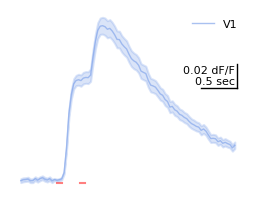

In [45]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

for iarea, area in enumerate(area_list):
	trace_grand_avg = trace_avg_list[iarea]
	trace_grand_sem = trace_sem_list[iarea]

	plt.plot(trace_grand_avg, 
		  alpha=0.7, linewidth=1, 
		  color=color_list[iarea], 
		  label=area
		  )
	plt.fill_between(np.arange(trace_grand_avg.shape[0]),
			trace_grand_avg - trace_grand_sem, 
			trace_grand_avg + trace_grand_sem,
			alpha=0.3, 
			color=color_list[iarea]
			)


# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01) + frame_shift
stim2_time = np.arange(9.5, 11.5, 0.01) + frame_shift
y = np.ones(stim1_time.shape) * (-0.001)
plt.plot(stim1_time, y, linewidth=1.5, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=1.5, color='r', alpha=0.5)


## vertical scale bar for df/f
vertical_bar_y_lower = 0.08
vertical_bar_x = trace_grand_avg.shape[0]
plt.plot([vertical_bar_x, vertical_bar_x], 
		 [vertical_bar_y_lower, vertical_bar_y_lower+0.02], 
		 linewidth=1, color='k');

## horizontal scale bar for sec
horiz_bar_len = frame_rate * 0.5
plt.plot([vertical_bar_x - horiz_bar_len, vertical_bar_x], 
		 [vertical_bar_y_lower, vertical_bar_y_lower], 
		 linewidth=1, color='k');

## text on the bottom of the scale bar
text_adjust_left = 1
text_adjust_up = 0.01
plt.text(vertical_bar_x - text_adjust_left, vertical_bar_y_lower+text_adjust_up+0.005, 
		 r'0.02 dF/F', ha='right', va='center', fontsize=8);
plt.text(vertical_bar_x - text_adjust_left, vertical_bar_y_lower+text_adjust_up, 
		 r'0.5 sec', ha='right', va='top', fontsize=8);


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.legend(frameon=False, fontsize=8);
plt.tight_layout();

# plt.savefig(dir_fig + '/fig2_trace_grand_avg_across_area_addV1multisess.svg')

# filter_cell_vis_R1
among vis_strict cell, filter by R1_ori0 > thresh

In [46]:
df_R1_ori0 = df_tidy[(df_tidy.stim2_id == 0) & (df_tidy.resp_id == 'R1') & (df_tidy.isi == 250)].groupby(['cell_id']).dfof.mean().abs().reset_index()
df_R1_ori0['filter_cell_R1_ori0'] = df_R1_ori0.dfof >= 0.01 # match filter of section "R1 & adp across area"
df_R1_ori0 = df_R1_ori0.drop(columns=['dfof'])

df_vis = df_tidy[['area', 'cell_id', 'filter_cell_vis', 'filter_cell_vis_strict']].groupby('cell_id').first().reset_index()
df_vis_R1_ori0 = df_vis.merge(df_R1_ori0, on='cell_id', how='outer')

df_vis_R1_ori0['both'] = df_vis_R1_ori0.filter_cell_vis_strict & df_vis_R1_ori0.filter_cell_R1_ori0
df_vis_R1_ori0['cell_type'] = 'none'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == True) & (df_vis_R1_ori0.filter_cell_R1_ori0 == False), 'cell_type'] = 'vis_only'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == False) & (df_vis_R1_ori0.filter_cell_R1_ori0 == True), 'cell_type'] = 'R1_ori0_only'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == True) & (df_vis_R1_ori0.filter_cell_R1_ori0 == True), 'cell_type'] = 'both'
df_vis_R1_ori0 = df_vis_R1_ori0[df_vis_R1_ori0.cell_type != 'none']

df_vis_R1 = df_vis_R1_ori0.groupby('area').cell_type.value_counts().unstack()
df_vis_R1 = df_vis_R1.iloc[::-1] # row order: V1, LM, LI
# df_vis_R1 = df_vis_R1.iloc[:, [2,3,0,1]] # column order

df_vis_R1['ncell_total'] = df_vis_R1.sum(axis=1)
print(df_vis_R1)
for col in df_vis_R1.columns[:-1]: # normalize by total cell number in each area
    df_vis_R1[col] = df_vis_R1[col] / df_vis_R1.ncell_total * 100 # convert to percentage
df_vis_hist = df_vis_R1.drop(columns='ncell_total', axis=1) # drop column ncell_total
print(df_vis_R1)

cell_type  R1_ori0_only  both  vis_only  ncell_total
area                                                
V1                  294   232        20          546
cell_type  R1_ori0_only       both  vis_only  ncell_total
area                                                     
V1            53.846154  42.490842  3.663004          546


# fig3b: adaptation across area

In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress FutureWarning

def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['cell_id']).dfof.mean().values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['cell_id']).dfof.mean().values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    
    gb_adp = gb_adp[(np.abs(gb_R1) >= 0.05)
                    ]
    return gb_adp


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)]
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True)]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
# gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
# gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])

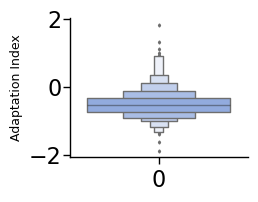

In [49]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_adp_V1], #, gb_adp_LM, gb_adp_LI],
                palette=['#85A7EB'], #, '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

# plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Adaptation Index', fontsize=9);
# plt.yticks(fontsize=8);
# ytickpos = np.arange(-2, 2.1, 2)
# ytickstr = ['{:.1f}'.format(item) for item in ytickpos]
# ax.set_yticks(ytickpos, labels=ytickstr, fontsize=8)

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_adp_by_area_addV1multisess.svg'))

# fig3c: R1 ori=0 across area

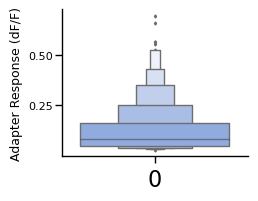

In [50]:
def R1_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values # avg over rep trials
    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.033)) 
                ] # NOTE: use the same cell filter as func adp_in_area
    return gb_R1


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)]
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True)]
gb_R1_V1 = R1_in_area(df_filter[df_filter.area == 'V1'])
# gb_R1_LM = R1_in_area(df_filter[df_filter.area == 'LM'])
# gb_R1_LI = R1_in_area(df_filter[df_filter.area == 'LI'])

cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_V1], #, gb_R1_LM, gb_R1_LI], 
                palette=['#85A7EB'], #, '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

# plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Adapter Response (dF/F)', fontsize=9);
plt.yticks(fontsize=8);

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1_by_area_addV1multisess.svg'))

# fig4be: tuning across area & ISI

In [51]:
df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]

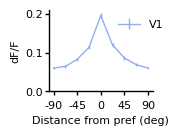

In [53]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1']): #, 'LM', 'LI']):
    tuning_pop = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    # print(tuning_pop.shape) # ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    tuning_pop_aligned_250 = np.zeros_like(tuning_pop_250)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori
        tuning_pop_aligned_250[icell] = np.roll(tuning_pop_250[icell], nori//2 - pref_ori[icell]) # align by pref_ori of noad (before adp)

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])


    ax.errorbar(np.arange(len(tuning_pop_avg)),
                tuning_pop_avg, 
                yerr=tuning_pop_sem, 
                label=iarea, alpha=0.9, linewidth=1, 
                color=color_list_noad[i],)
    
    # ax[1].errorbar(np.arange(len(tuning_pop_avg_250)),
    #             tuning_pop_avg_250, 
    #             yerr=tuning_pop_sem_250, 
    #             label=iarea, alpha=.7, linewidth=1, 
    #             color=color_list_250[i],)

xlabels = [str(int(t)) for t in np.arange(-90, 90 + 180/nori*2, 180/nori*2)]
ax.set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels, fontsize=8);
ylim_upper = ax.get_ylim()[1]
yticks = np.arange(0, ylim_upper, 0.1)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);

ax.set_xlabel('Distance from pref (deg)', fontsize=8)
ax.set_ylabel('dF/F', fontsize=8)
ax.legend(frameon=False, loc='upper right', fontsize=8, bbox_to_anchor=(1.2, 1));

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

sns.despine();
# fig.savefig(os.path.join(dir_fig, 'tuning_curve_R1_by_area_addV1multisess.svg'), bbox_inches='tight')

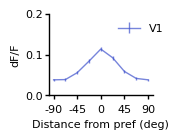

In [54]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1']):
    tuning_pop = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    # print(tuning_pop.shape) # ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    tuning_pop_aligned_250 = np.zeros_like(tuning_pop_250)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori
        tuning_pop_aligned_250[icell] = np.roll(tuning_pop_250[icell], nori//2 - pref_ori[icell]) # align by pref_ori of noad (before adp)

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])


    # ax.errorbar(np.arange(len(tuning_pop_avg)),
    #             tuning_pop_avg, 
    #             yerr=tuning_pop_sem, 
    #             label=iarea, alpha=0.9, linewidth=1, 
    #             color=color_list_noad[i],)
    
    ax.errorbar(np.arange(len(tuning_pop_avg_250)),
                tuning_pop_avg_250, 
                yerr=tuning_pop_sem_250, 
                label=iarea, alpha=.7, linewidth=1, 
                color=color_list_250[i],)

xlabels = [str(int(t)) for t in np.arange(-90, 90 + 180/nori*2, 180/nori*2)]
ax.set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels, fontsize=8);
ylim_upper = 0.2 # taken from tuning_curve_by_area_vis_R1_figsize
yticks = np.arange(0, ylim_upper+0.05, 0.1)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);

ax.set_xlabel('Distance from pref (deg)', fontsize=8)
ax.set_ylabel('dF/F', fontsize=8)
ax.legend(frameon=False, loc='upper right', fontsize=8, bbox_to_anchor=(1.2, 1));

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

sns.despine();
# fig.savefig(os.path.join(dir_fig, 'tuning_curve_R2_by_area_addV1multisess.svg'), bbox_inches='tight')

# fig4cf: gOSI across areas
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)   
[Ukita 2020](https://www.sciencedirect.com/science/article/pii/S089360802030054X)  
no rerun

In [55]:
# for icell in tqdm(df_tuning.cell_id.unique()): # NOTE: df_tuning cells already passed R1-ori0 filter. takes 5 min
#     df_cell = df_tuning[df_tuning.cell_id == icell]

#     # tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
#     # tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

#     ## convert tuning_isi from a string of list to an actual list
#     tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
#     if type(tuning_noad) == str:
#         tuning_noad = tuning_noad.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_noad = [float(i) for i in tuning_noad if len(i) > 0] # remove empty string
#     tuning_noad = np.array(tuning_noad) - min(tuning_noad) # ensure all values are non negative

#     tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
#     if type(tuning_250) == str:
#         tuning_250 = tuning_250.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_250 = [float(i) for i in tuning_250 if len(i) > 0]
#     tuning_250 = np.array(tuning_250) - min(tuning_250)


#     theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
#     sin_arr = np.sin(2 * theta_arr)
#     cos_arr = np.cos(2 * theta_arr)

#     gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
#     gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

# df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)

100%|██████████| 587/587 [00:42<00:00, 13.94it/s]


In [56]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_gosi_jin2019.csv'
# df_tuning.to_csv(os.path.join(dir_data, csv_filename), index=False)
df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

In [57]:
df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]

df_gOSI = df_filter.groupby('cell_id', sort=False)[['area', 
                                                    'gOSI_noad', 'gOSI_250']
                                                    ].first().reset_index()
df_gOSI.sample(5, random_state=0)

,cell_id,area,gOSI_noad,gOSI_250
15,712_170503_15,V1,0.740923,0.368635
124,674_170324_62,V1,0.554788,0.359688
141,711_170503_25,V1,0.538523,0.430334
263,574_170510_26,V1,0.415246,0.513451
170,711_170503_32,V1,0.510666,0.279772


In [58]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
# color_list_250 = color_list[1::2]
color_list_250 = ['#7784db', '#d5ad8b', '#ae9eed'] # color-picker from tuning curve by area and isi

isi_now = 6000
# isi_now = 250

if isi_now == 6000:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
    # gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
    # gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values
    palette = color_list_noad
elif isi_now == 250:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
    # gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
    # gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values
    palette = color_list_250

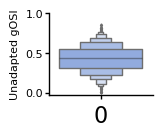

In [60]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

sns.boxenplot(data=[gOSI_V1], #, gOSI_LM, gOSI_LI], 
            palette=palette, 
            linewidth=1, 
            flier_kws=dict(s=1), 
            ax=ax,
            )

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();

yticks = np.arange(0, 1.1, 0.5)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);
ax.set_ylabel('dF/F', fontsize=8)

# plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=8);
if isi_now == 6000:
    isi_str = 'Unadapted'
elif isi_now == 250:
    isi_str = 'Adapted'
plt.ylabel(f'{isi_str} gOSI', fontsize=8);

# plt.savefig(os.path.join(dir_fig, f'gOSI_across_area_{isi_now}ms_addV1multisess.svg'), bbox_inches='tight')

In [61]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
# color_list_250 = color_list[1::2]
color_list_250 = ['#7784db', '#d5ad8b', '#ae9eed'] # color-picker from tuning curve by area and isi

# isi_now = 6000
isi_now = 250

if isi_now == 6000:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
    # gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
    # gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values
    palette = color_list_noad
elif isi_now == 250:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
    # gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
    # gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values
    palette = color_list_250

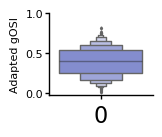

In [62]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

sns.boxenplot(data=[gOSI_V1], #, gOSI_LM, gOSI_LI], 
            palette=palette, 
            linewidth=1, 
            flier_kws=dict(s=1), 
            ax=ax,
            )

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();

ylim_upper = 1.1
yticks = np.arange(0, ylim_upper, 0.5)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);
ax.set_ylabel('dF/F', fontsize=8)

# plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=8);
if isi_now == 6000:
    isi_str = 'Unadapted'
elif isi_now == 250:
    isi_str = 'Adapted'
plt.ylabel(f'{isi_str} gOSI', fontsize=8);

# plt.savefig(os.path.join(dir_fig, f'gOSI_across_area_{isi_now}ms_addV1multisess.svg'), bbox_inches='tight')

# fig4dg: well-max cell % stacked histogram

In [194]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
# df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_44832\1520611008.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))


### well-max, ISI 6000

In [63]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                              & (df_tuning.isi == 6000)] # NOTE: well max percent within vis cells, based on R1 (isi 6k)
                    .groupby('cell_id').first())

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max

df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI
# df_well_hist = df_well_hist.iloc[:, [1, 0]] # column order

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
print(df_well_hist)

for col in df_well_hist.columns[:-1]: # normalize by total cell number in each area
    df_well_hist[col] = df_well_hist[col] / df_well_hist.ncell_total * 100 # convert to percentage
df_well_hist = df_well_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
df_well_hist

well_str  none  well-tuned  ncell_total
area                                   
V1         212         270          482


well_str,none,well-tuned
area,,
V1,43.983402,56.016598


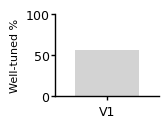

In [64]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1

ax = (df_well_hist['well-tuned']
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["teal", "darkturquoise", "turquoise", 'aquamarine']), 
        colormap=ListedColormap(['lightgray']), 
        width=0.8) # make bar thinner
        );

# ## set alpha for darkest color
# alpha = 0.7
# plt.gca().patches[0].set_alpha(alpha)
# plt.gca().patches[1].set_alpha(alpha)
# plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks([0, 50, 100], fontsize=9);
plt.ylim([0, 100])
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Well-tuned %', fontsize=8, ); # labelpad=-5
# plt.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8);
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'wellmax_in_vis_ncell_by_area_addV1multisess.svg'), bbox_inches='tight')

### well-max, ISI 250

In [65]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                              & (df_tuning.isi == 250)] # NOTE: well max percent within vis cells, based on R2 (isi 250)
                    .groupby('cell_id').first())

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max

df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI
# df_well_hist = df_well_hist.iloc[:, [1, 0]] # column order

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
print(df_well_hist)

for col in df_well_hist.columns[:-1]: # normalize by total cell number in each area
    df_well_hist[col] = df_well_hist[col] / df_well_hist.ncell_total * 100 # convert to percentage
df_well_hist = df_well_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
df_well_hist

well_str  none  well-tuned  ncell_total
area                                   
V1         212         270          482


well_str,none,well-tuned
area,,
V1,43.983402,56.016598


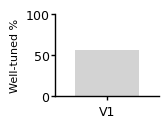

In [66]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1

ax = (df_well_hist['well-tuned']
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["teal", "darkturquoise", "turquoise", 'aquamarine']), 
        colormap=ListedColormap(['lightgray']), 
        width=0.8) # make bar thinner
        );

# ## set alpha for darkest color
# alpha = 0.7
# plt.gca().patches[0].set_alpha(alpha)
# plt.gca().patches[1].set_alpha(alpha)
# plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks([0, 50, 100], fontsize=9);
plt.ylim([0, 100])
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Well-tuned %', fontsize=8, ); # labelpad=-5
# plt.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8);
sns.despine();

# plt.savefig(os.path.join(dir_fig, 'wellmax_in_vis_ncell_by_area_addV1multisess_isi250.svg'), bbox_inches='tight')

# fig4h: tuning bias like plot for (g)OSI
for vis + well-tuned cells

In [68]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_gosi_jin2019.csv'
df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))

In [69]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    ]
df_filter['gOSI_change'] = df_filter.gOSI_250 - df_filter.gOSI_noad
df_filter = df_filter.groupby('cell_id').first().reset_index()
df_pref_unadapted_distance_bin = df_filter.groupby('cell_id').pref_unadapted_distance_bin.first().reset_index()

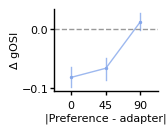

In [70]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

ax = sns.pointplot(x='pref_unadapted_distance_bin', y='gOSI_change', data=df_filter, 
                   hue='area', hue_order=['V1'], #, 'LM', 'LI'],
                   dodge=True, markers='.', scale = 0.3,
                   palette=color_list_noad,
                   errorbar=('ci', 68),
                   )
plt.axhline(0, color='gray', linestyle='--', alpha=.3);

# ypos_sig = 0.05
# ax.text(0.08, ypos_sig-0.03, '***', transform=ax.transAxes, fontsize=8)
# ax.text(0.42, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)
# ax.text(0.75, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)

plt.setp(ax.collections, alpha=1);
plt.setp(ax.lines, alpha=.8, linewidth=1);
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.xlabel('|Preference - adapter|', fontsize=8, labelpad=2);
plt.ylabel('Δ gOSI', fontsize=8, labelpad=1);
ax.get_legend().remove()
# plt.legend(frameon=False, fontsize=8, 
#         #    loc='upper right', 
#            bbox_to_anchor=(1, 0.8)
#            );
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'gOSI_delta_wellmax_by_area_addV1multisess.svg'), bbox_inches='tight')

# fig4i: tuning bias plot

In [258]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
# df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_44832\3429901358.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))


In [71]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    & (df_tidy.isi == 250)
                    ]
df_filter = df_filter.groupby('cell_id').first().reset_index() # drop duplicate cell_id
df_filter.groupby('area').cell_id.nunique()

area
V1    270
Name: cell_id, dtype: int64

In [72]:
bias_0_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'V1')].tuning_bias.values
# bias_0_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LM')].tuning_bias.values
# bias_0_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LI')].tuning_bias.values
# print(stats.kruskal(bias_0_V1, bias_0_LM, bias_0_LI))

bias_45_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'V1')].tuning_bias.values
# bias_45_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LM')].tuning_bias.values
# bias_45_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LI')].tuning_bias.values
# print(stats.kruskal(bias_45_V1, bias_45_LM, bias_45_LI))

bias_90_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'V1')].tuning_bias.values
# bias_90_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LM')].tuning_bias.values
# bias_90_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_0_V1, bias_45_V1, bias_90_V1))

KruskalResult(statistic=40.52585364159282, pvalue=1.5846111026988346e-09)


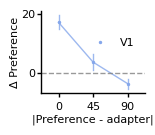

In [74]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', scale = 0.3,
                   palette=['#85A7EB', '#F6CD51', '#D1A6DE'],
                   errorbar=('ci', 68),
                   )
plt.axhline(0, color='gray', linestyle='--', alpha=.3);

# ypos_sig = 0.05
# ax.text(0.08, ypos_sig-0.03, '***', transform=ax.transAxes, fontsize=8)
# ax.text(0.42, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)
# ax.text(0.75, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)

plt.setp(ax.collections, alpha=1);
plt.setp(ax.lines, alpha=.8, linewidth=1);
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.xlabel('|Preference - adapter|', fontsize=8, labelpad=2);
plt.ylabel('Δ Preference', fontsize=8, labelpad=1);
plt.legend(frameon=False, fontsize=8, 
        #    loc='upper right', 
           bbox_to_anchor=(1, 0.8)
           );
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'tuning_bias_wellmax_by_area_addV1multisess.svg'), bbox_inches='tight')

# decorr & noise

In [75]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

def get_df_decorr(df_tidy, current_area, filter_cell=None):
    # df_decorr = df_tidy[['dfof', 
    #                     'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id', 
    #                     'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 'filter_cell_well_max',
    #                     'area', 'mouse', 'date', 'sess'
    #                     ]]
    df_decorr = df_tidy.copy()

    df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                              # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    
    df_decorr['mousedate'] = df_decorr.mouse.astype(str) + '_' + df_decorr.date.astype(str)
    df_decorr['trial_id'] = df_decorr['mousedate'] + '_' + df_decorr['trial_id'].astype(str) # make trial_id unique across mousedate

    df_decorr = df_decorr[(df_decorr.isi != 750)
                          & (df_decorr.resp_id == 'R2') # repre of 8ori, with or without 0 deg adapter
                          & (df_decorr.area == current_area)
                          & (df_decorr.filter_cell_vis == True)
                        #   & (df_decorr.filter_cell_vis_strict == True)
                         ]
    if filter_cell == 'well_fit':
        df_decorr = df_decorr[(df_decorr.filter_cell_well_fit == True)]
    elif filter_cell == 'well_max':
        well_max_cell = df_decorr[(df_decorr.filter_cell_well_max == True)].cell_id.unique() # NOTE: well_max is for each cell and isi
        df_decorr = df_decorr[df_decorr.cell_id.isin(well_max_cell)]
    
    return df_decorr


def sim_sess(df_decorr, ref_ori=90, metric='cos_sim'):
    df_sim = pd.DataFrame(columns=['isi', 'stim2_dist', 'mousedate', 'sim'])
    sim_across_sess = []
    for mousedate in tqdm(df_decorr.mousedate.unique()):

        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.mousedate == mousedate].cell_id.nunique() <= 10: 
            continue
        
        df_pop_vec = (df_decorr[df_decorr.mousedate == mousedate]
                    .groupby(['isi', 'stim2_dist', 'cell_id'])
                    .dfof.mean().reset_index()
                    .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                    ) # rows: isi 250 -> 6000, within each isi, stim2_dist 0 -> 90. cols: cell_id
        nori = df_decorr.stim2_dist.nunique()
        nisi_now = df_decorr.isi.nunique() # discarded isi 750
        # isi_list = df_decorr.isi.unique()
        isi_list = [250, 6000] # same as df_pop_vec isi order

        sim_isess = []
        for iisi in range(nisi_now):
            if ref_ori == 90:
                iref = iisi*nori + 4  # -1 (0-based indexing) and +1 (go to next isi) cancel out
                pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: ref ori target resp
            elif ref_ori == 0:
                iref = iisi*nori
                pop_vec_ref = df_pop_vec.iloc[iref, :].values

            for iori in range(nori): # iori = 0-4, aka ori distance from ref ori
                irow = iisi * nori + iori
                pop_vec_ori = df_pop_vec.iloc[irow, :].values

                if ref_ori == 'neighbor':
                    if iori > 0:
                        pop_vec_ref = df_pop_vec.iloc[irow-1, :].values # take the previous ori (aka left neighbor) as ref
                    else:
                        pop_vec_ref = pop_vec_ori.copy() # for iori = 0, ref is itself

                if metric == 'cos_sim':
                    sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                elif metric == 'dot_prod':
                    sim = dot(pop_vec_ref, pop_vec_ori)
                elif metric == 'neural_angle':
                    tmp = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                    tmp = np.round(tmp, 4) # prevent numerical error like 1.0000000000000002
                    sim = np.arccos(tmp) * 180 / np.pi # cos_simil to simil rad to deg, "neural angle"
                    
                df_sim = pd.concat([df_sim, pd.DataFrame({'isi': isi_list[iisi], 'stim2_dist': iori, 'mousedate': mousedate, 'sim': sim}, index=[0])])
                sim_isess.append(sim)
        sim_across_sess.append(sim_isess) # n of decorrelation pairs (nisi * nori)    
    sim_across_sess = np.array(sim_across_sess) # n of boot x n of decorrelation pairs (nisi * nori). NOTE: isi order is 250 -> 6000
    return sim_across_sess, df_sim


def snr_pop_vec_sess_1trial(df_decorr, noise_format='len'):
    df_noise = pd.DataFrame(columns=['isi', 'stim2_dist', 'mousedate', 'noise'])
    noise_sess = []
    for mousedate in tqdm(df_decorr.mousedate.unique()):
        
        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.mousedate == mousedate].cell_id.nunique() <= 5: 
            continue

        df_decorr_sess = df_decorr[df_decorr.mousedate == mousedate]
        ncell_sess = df_decorr_sess.cell_id.nunique()

        ## get pop_vec_avg of each isi-stim2_dist condition
        df_pop_vec_agg = (df_decorr_sess
                            .groupby(['isi', 'stim2_dist', 'cell_id'])
                            .dfof.mean().reset_index() # cell-level agg, under each isi-stim2_dist condition
                            .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                            )
        
        ## get pop_vec of single trials
        noise_isess = [] # noise in sess, across isi-stim2_dist condition
        isi_arr = np.array([250, 6000]) # isi is sorted in df_pop_vec_agg due to pivot_table
        stim2_dist_arr = np.arange(0, 90+1, 22.5)

        for iisi, isi_val in enumerate(isi_arr):
            for idist, dist_val in enumerate(stim2_dist_arr):
                pop_vec_1trial_cond = (df_decorr_sess[(df_decorr_sess.isi == isi_val) 
                                                        & (df_decorr_sess.stim2_dist == dist_val)]
                                                        .pivot_table(index='trial_id', columns='cell_id', values='dfof')
                                                        .values) # ntrial x ncell
                pop_vec_agg_cond = df_pop_vec_agg.loc[(isi_val, dist_val), :].values # 1 x ncell

                noise = pop_vec_1trial_cond - pop_vec_agg_cond
                noise_across_trial = np.median(noise, axis=0) # avg across trials
                noise_norm = np.linalg.norm(noise_across_trial) / np.sqrt(ncell_sess) # linalg.norm across cells (pop vec), then normalize by sqrt(ncell)

                if noise_format == 'angle':
                    # ## find angle between pop_vec_1trial_cond and pop_vec_agg_cond. expect noise_angle to not need normaliz
                    # ntrial = pop_vec_1trial_cond.shape[0]
                    # noise_angle = np.zeros(ntrial)
                    # for itrial in range(ntrial):
                    #     noise_angle_itrial = (np.arccos(np.dot(pop_vec_1trial_cond[itrial, :], pop_vec_agg_cond) 
                    #                             / (np.linalg.norm(pop_vec_1trial_cond[itrial, :]) * np.linalg.norm(pop_vec_agg_cond))) 
                    #                             * 180 / np.pi) # angle between single trial vec and pop vec = cos simil -> acos -> rad to deg
                    #     noise_angle[itrial] = noise_angle_itrial
                    # noise_angle_across_trial = np.median(noise_angle)

                    ## arctan noise_norm / pop_vec_agg_cond should be equivalent to angle between pop_vec_1trial_cond and pop_vec_agg_cond
                    noise_angle_across_trial = np.arctan(np.linalg.norm(noise_across_trial) / np.linalg.norm(pop_vec_agg_cond)) * 180 / np.pi # rad to deg

                if noise_format == 'len':
                    noise_isess.append(noise_norm)
                    df_noise = pd.concat([df_noise, pd.DataFrame({'isi': isi_val, 'stim2_dist': dist_val, 'mousedate': mousedate, 'noise': noise_norm}, index=[0])])
                elif noise_format == 'angle':
                    noise_isess.append(noise_angle_across_trial)
                    df_noise = pd.concat([df_noise, pd.DataFrame({'isi': isi_val, 'stim2_dist': dist_val, 'mousedate': mousedate, 'noise': noise_angle_across_trial}, index=[0])])
                
        noise_sess.append(noise_isess) # n of decorrelation pairs (nisi * nori)
    noise_sess = np.array(noise_sess) # NOTE: isi order is 250 -> 6000
    return noise_sess, df_noise.reset_index(drop=True)

In [78]:
### well max filter

df_decorr_V1 = get_df_decorr(df_tidy, current_area='V1', filter_cell='well_max')
# df_decorr_LM = get_df_decorr(df_tidy, current_area='LM', filter_cell='well_max')
# df_decorr_LI = get_df_decorr(df_tidy, current_area='LI', filter_cell='well_max')

cos_sim_V1_neighbor_sess, df_cossim_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LM_neighbor_sess, df_cossim_LM_neighbor_sess = sim_sess(df_decorr_LM, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LI_neighbor_sess, df_cossim_LI_neighbor_sess = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='cos_sim')

dot_prod_V1_neighbor_sess, df_prod_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='dot_prod')
# dot_prod_LM_neighbor_sess, df_prod_LM_neighbor_sess = sim_sess(df_decorr_LM, ref_ori='neighbor', metric='dot_prod')
# dot_prod_LI_neighbor_sess, df_prod_LI_neighbor_sess = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='dot_prod')

# noise_sess_V1_1trial, df_noise_V1_1trial = snr_pop_vec_sess_1trial(df_decorr_V1)
# noise_sess_LM_1trial, df_noise_LM_1trial = snr_pop_vec_sess_1trial(df_decorr_LM)
# noise_sess_LI_1trial, df_noise_LI_1trial = snr_pop_vec_sess_1trial(df_decorr_LI)

noise_sess_V1_1trial, df_noise_V1_1trial = snr_pop_vec_sess_1trial(df_decorr_V1, noise_format='angle')
# noise_sess_LM_1trial, df_noise_LM_1trial = snr_pop_vec_sess_1trial(df_decorr_LM, noise_format='angle')
# noise_sess_LI_1trial, df_noise_LI_1trial = snr_pop_vec_sess_1trial(df_decorr_LI, noise_format='angle')

clear_output()

# fig5de: decorr cossim

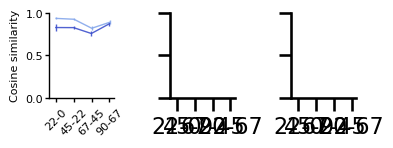

In [79]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

# cos_sim_LI_neighbor_sess, _ = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] < 0] = np.median(cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] > 0]) # LI adapted 22-0 exclude an outlier

for iarea, cos_sim_boots in enumerate([cos_sim_V1_neighbor_sess, ]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori)[1:] + 0.01, 
                       y=cos_sim_avg[nori+1:],
                       yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori)[1:] - 0.01, 
                       y=cos_sim_avg[1:nori],
                       yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', '45-22', '67-45', '90-67'], rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.5)
    ax[iarea].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.4, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='lower right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Cosine similarity', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_cossim_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [81]:
df_ratio = pd.DataFrame(columns=['stim2_dist', 'mousedate', 'noise_ratio', 'area'])
for iarea, df_iarea in enumerate([df_cossim_V1_neighbor_sess, ]):

    df_pivot = df_iarea.pivot_table(index=['stim2_dist', 'mousedate'], 
                                                      columns='isi', 
                                                      values='sim').reset_index()
    df_pivot.columns = ['stim2_dist', 'mousedate', 'sim_250', 'sim_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['stim2_dist', 'mousedate', 
                                    'sim_250', 'sim_6000',
                                    'sim_ratio', 'area'])
    for key, group in df_pivot.groupby(['stim2_dist']):
        group['sim_250'] = np.sort(group['sim_250'].values)
        group['sim_6000'] = np.sort(group['sim_6000'].values)
        group['sim_ratio'] = group['sim_250'] / group['sim_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

# model = ols('sim_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_ratio).fit()
# print(sm.stats.anova_lm(model, typ=2))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\2353977413.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[(df_ratio.stim2_dist != 0)
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\2353977413.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[(df_ratio.stim2_dist != 0)
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\2353977413.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[(df_ratio.stim2_dist != 0)


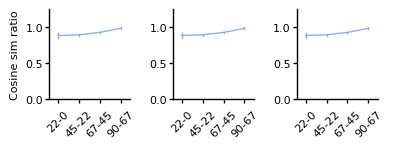

In [84]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[(df_ratio.stim2_dist != 0) 
                                    #  & (df_ratio.sim_ratio > 0)
                                     ],
                       x='stim2_dist', y='sim_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(1, 5)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.25
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Cosine sim ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_cossim_ratio_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# fig5bc: decorr dot product

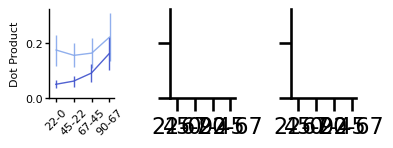

In [85]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, df_decorr_LM, df_decorr_LI]:
    ncell_area.append(df_decorr.cell_id.nunique())

for iarea, cos_sim_boots in enumerate([dot_prod_V1_neighbor_sess, ]):

    ## normalize sim values in sim_boots by ncell, then by max
    cos_sim_boots = cos_sim_boots / ncell_area[iarea]
    cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots)
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori)[1:] + 0.01, 
                       y=cos_sim_avg[nori+1:],
                       yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori)[1:] - 0.01, 
                       y=cos_sim_avg[1:nori],
                       yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', '45-22', '67-45', '90-67'], rotation=45, fontsize=8);
    ylim_upper = ax[iarea].get_ylim()[1]
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(0, ylim_upper, 0.2)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.4, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='upper right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Dot Product', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_dotprod_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [86]:
df_ratio = pd.DataFrame(columns=['stim2_dist', 'mousedate', 'noise_ratio', 'area'])
for iarea, df_iarea in enumerate([df_prod_V1_neighbor_sess, ]):

    df_pivot = df_iarea.pivot_table(index=['stim2_dist', 'mousedate'], 
                                                      columns='isi', 
                                                      values='sim').reset_index()
    df_pivot.columns = ['stim2_dist', 'mousedate', 'sim_250', 'sim_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['stim2_dist', 'mousedate', 
                                    'sim_250', 'sim_6000',
                                    'sim_ratio', 'area'])
    for key, group in df_pivot.groupby(['stim2_dist']):
        group['sim_250'] = np.sort(group['sim_250'].values)
        group['sim_6000'] = np.sort(group['sim_6000'].values)
        group['sim_ratio'] = group['sim_250'] / group['sim_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

# model = ols('sim_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_ratio).fit()
# print(sm.stats.anova_lm(model, typ=2))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\788448430.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[df_ratio.stim2_dist != 0],
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\788448430.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[df_ratio.stim2_dist != 0],
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\788448430.py:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_ratio[df_ratio.stim2_dist != 0],


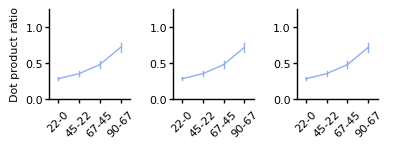

In [87]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[df_ratio.stim2_dist != 0], 
                       x='stim2_dist', y='sim_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(1, 5)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.25
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Dot product ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_prod_ratio_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# fig5fg: decorr noise

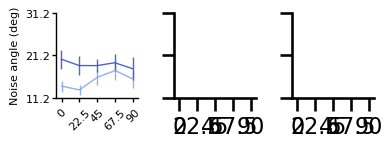

In [88]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, ]:
    ncell_area.append(df_decorr.cell_id.nunique())

# for iarea, df in enumerate([df_noise_V1_1trial, df_noise_LM_1trial, df_noise_LI_1trial]):

    # df['noise'] = df.noise.apply(lambda x: x*1e17 if x < 1e-17 else x) # scale up for plotting
    # ax[iarea] = sns.lineplot(data=df, 
    #                          x='stim2_dist', y='noise', hue='isi', 
    #                         errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
    #                         ax=ax[iarea],
    #                         palette=color_list[iarea*2 : iarea*2+1+1], linewidth=1, alpha=0.9)
    
for iarea, cos_sim_boots in enumerate([noise_sess_V1_1trial, ]):
    if np.min(cos_sim_boots) < 1e-17:
        cos_sim_boots *= 1e17
    # cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots, axis=1, keepdims=True) # normalize by max across isi-stim2_dist
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    cos_sim_sem = np.std(cos_sim_boots, axis=0) / np.sqrt(cos_sim_boots.shape[0])
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori) + 0.01, 
                       y=cos_sim_avg[nori:],
                       yerr=cos_sim_sem[nori:],
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori) - 0.01, 
                       y=cos_sim_avg[:nori],
                       yerr=cos_sim_sem[:nori],
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )

    # xticks = np.arange(0, 90+1, 22.5)
    xticks = np.arange(0, 5)
    ax[iarea].set_xticks(xticks, ['0', '22.5', '45', '67.5', '90'], rotation=45, fontsize=8);
    ylim_lower = np.round(ax[iarea].get_ylim()[0], 1)
    ylim_upper = np.round(ax[iarea].get_ylim()[1], 1)
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(ylim_lower-0.1, ylim_upper+10.1, 10)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_lower = ax[iarea].get_xlim()[0]
    xlim_upper = ax[iarea].get_xlim()[1]
    # xlim_pad = 0.5
    xlim_pad = 0.1
    ax[iarea].set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)

    # ax[iarea].legend_.remove()
    ax[iarea].set_xlabel('');
    ax[iarea].set_ylabel('');

    

ax[0].set_ylabel('Noise angle (deg)', fontsize=8);
sns.despine();
fig.tight_layout(); 

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_noise_angle.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [89]:
## run two way anova on adp & ori pair for each panel: https://www.statology.org/two-way-anova-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_V1_1trial).fit()
print(sm.stats.anova_lm(model, typ=2))

# model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_LM_1trial).fit()
# print(sm.stats.anova_lm(model, typ=2))

# model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_LI_1trial).fit()
# print(sm.stats.anova_lm(model, typ=2))

                           sum_sq     df         F    PR(>F)
C(isi)                 441.149398    1.0  8.337946  0.004676
C(stim2_dist)           86.741233    4.0  0.409863  0.801213
C(isi):C(stim2_dist)   102.234099    4.0  0.483069  0.748115
Residual              5819.950851  110.0       NaN       NaN


In [92]:
df_noise_ratio = pd.DataFrame(columns=['stim2_dist', 'mousedate', 'noise_ratio', 'area'])
for iarea, df_noise_iarea in enumerate([df_noise_V1_1trial, ]):

    df_noise_iarea_pivot = df_noise_iarea.pivot_table(index=['stim2_dist', 'mousedate'], 
                                                      columns='isi', 
                                                      values='noise').reset_index()
    df_noise_iarea_pivot.columns = ['stim2_dist', 'mousedate', 'noise_250', 'noise_6000']
    df_noise_iarea_pivot.index = np.arange(df_noise_iarea_pivot.shape[0])

    df_noise_iarea_concat = pd.DataFrame(columns=['stim2_dist', 'mousedate', 
                                            'noise_250', 'noise_6000',
                                            'noise_ratio', 'area'])
    for key, group in df_noise_iarea_pivot.groupby(['stim2_dist']):
        group['noise_250'] = np.sort(group['noise_250'].values)
        group['noise_6000'] = np.sort(group['noise_6000'].values)
        group['noise_ratio'] = group['noise_250'] / group['noise_6000']
        group['area'] = area_list[iarea]
        df_noise_iarea_concat = pd.concat([df_noise_iarea_concat, group])

    df_noise_ratio = pd.concat([df_noise_ratio, df_noise_iarea_concat])
df_noise_ratio.head()

# model = ols('noise_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_noise_ratio).fit()
# print(sm.stats.anova_lm(model, typ=2))

,stim2_dist,mousedate,noise_ratio,area,noise_250,noise_6000
0,0.0,574_170510,0.882887,V1,7.443997,8.431431
1,0.0,674_170324,1.021808,V1,10.955230,10.721422
2,0.0,684_170327,1.113334,V1,12.237886,10.992104
3,0.0,689_170323,1.327269,V1,15.100332,11.376998
4,0.0,696_170323,1.365594,V1,15.754818,11.536975


C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\4162194860.py:14: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_noise_ratio, x='stim2_dist', y='noise_ratio', hue='area',
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\4162194860.py:14: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_noise_ratio, x='stim2_dist', y='noise_ratio', hue='area',
C:\Users\ll357\AppData\Local\Temp\7\ipykernel_91064\4162194860.py:14: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  iax = sns.lineplot(data=df_noise_ratio, x='stim2_dist', y='noise_ratio', hue='area',


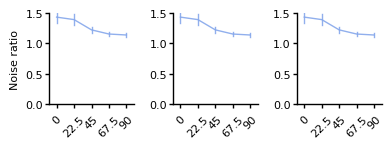

In [93]:
## plot with df, sorted within dist
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_noise_ratio, x='stim2_dist', y='noise_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(0, 90+1, 22.5)
    iax.set_xticks(xticks, ['0', '22.5', '45', '67.5', '90'], fontsize=8, rotation=45);
    xlim_upper = iax.get_xlim()[1]
    iax.set_xlim(-10, 90+10)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.5
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Noise ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_noise_angle_ratio.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# deprecated from here on

## fig6a: neighbor pv decoder

(6, 4)
p = 0.6872
(22, 4)
p = 0.9208
(18, 4)
p = 0.3363


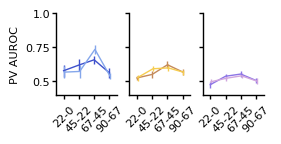

In [3]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

dir_pop_vec = r'C:\Users\ll357\Documents\inter\results\decoder_grat8\pop vec decoder jin2019 jeff'.replace('\\', '/')
xticklabels = ['0', '22.5', '45', '67.5', '90']
for i, iarea in enumerate(['V1', 'LM', 'LI']):

# pop_vec_decoder_neighbor_LI_dvall_PV_10wellmax_vecnorm
    res = sio.loadmat(os.path.join(dir_pop_vec, 
                                   f'pop_vec_decoder_neighbor_{iarea}_dvall_PV_10wellmax_notnorm.mat'
                                   ))
    acc_250 = res['tmp_250'][:, 1:] # drop first col, where stim2_dist=0
    acc_750 = res['tmp_750'][:, 1:] # in 6k.mat, 750 is actually 6000
    print(acc_250.shape)

    ## one-sided paired t-test
    _, p = ttest_rel(acc_250[:, 0], acc_750[:, 0], alternative='two-sided')
    print(f'p = {np.round(p, 4)}')
    
    ax[i].errorbar(x=np.arange(acc_250.shape[1]),
                y=np.mean(acc_250, axis=0),
                yerr=np.std(acc_250, axis=0) / np.sqrt(acc_250.shape[0]),
                color=color_list_250[i], linewidth=1,
                label=f'{iarea} adapted')

    ax[i].errorbar(x=np.arange(acc_750.shape[1]) + 0.05,
                   
                y=np.mean(acc_750, axis=0),
                yerr=np.std(acc_750, axis=0) / np.sqrt(acc_750.shape[0]),
                color=color_list_noad[i], linewidth=1,
                label=f'{iarea} unadapted')
    
    xticklabels = ['22-0', '45-22', '67-45', '90-67']
    ax[i].set_xticks(range(acc_250.shape[1]), xticklabels, rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.25)
    ax[i].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[i].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[i].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[i].get_xlim()[1]
    ax[i].set_xlim(-0.5, xlim_upper+0.1)
    ax[i].spines['left'].set_linewidth(1) # set axis width
    ax[i].spines['bottom'].set_linewidth(1)
    # ax[i].legend(frameon=False, loc='upper left', fontsize=8);

ax[1].set_xlabel('', fontsize=8)
ax[0].set_ylabel('PV AUROC', fontsize=8)
plt.ylim(0.4, 1.0);
sns.despine();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_auroc_across_area_neighbor_dvall_PV_10wellmax_notnorm.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [4]:
df_decode = pd.DataFrame(columns=['isi', 'ori_pair', 'acc', 'area', 'isess_area'])
for i, iarea in enumerate(['V1', 'LM', 'LI']):
    res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_neighbor_{iarea}_dvall_PV_10wellmax_notnorm.mat'))

    for iisi, isi_val in enumerate([250, 750]): # in *6k.mat, 750 is actually 6000
        acc = res[f'tmp_{isi_val}'][:, 1:] # drop first col, where stim2_dist=0
        # print(acc.shape)

        for iori, ori_pair in enumerate(['22-0', '45-22', '67-45', '90-67']):
            for isess in range(acc.shape[0]):
                df_decode = df_decode = pd.concat([df_decode, 
                                                   pd.DataFrame({'isi': isi_val, 
                                                                'ori_pair': ori_pair, 
                                                                'acc': acc[isess, iori], 
                                                                'area': iarea, 
                                                                'isess_area': isess, # session index within area
                                                                }, index=[0])
                                                                ])
                                              
df_decode = df_decode.reset_index(drop=True)
# assert len(df_decode) == nsess * nisi * nori_pair

In [5]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
for df_prod in [df_decode[df_decode.area == 'V1'], 
                df_decode[df_decode.area == 'LM'], 
                df_decode[df_decode.area == 'LI']]:
    
    model = ols('acc ~ C(isi) + C(ori_pair) + C(isi):C(ori_pair)', data=df_prod).fit()
    print(sm.stats.anova_lm(model, typ=2))

                      sum_sq    df         F    PR(>F)
C(isi)              0.000032   1.0  0.003051  0.956228
C(ori_pair)         0.151196   3.0  4.821461  0.005865
C(isi):C(ori_pair)  0.026530   3.0  0.846004  0.476914
Residual            0.418120  40.0       NaN       NaN
                      sum_sq     df         F    PR(>F)
C(isi)              0.001043    1.0  0.099935  0.752301
C(ori_pair)         0.155536    3.0  4.967616  0.002500
C(isi):C(ori_pair)  0.023762    3.0  0.758915  0.518648
Residual            1.753363  168.0       NaN       NaN
                      sum_sq     df         F    PR(>F)
C(isi)              0.000238    1.0  0.032923  0.856286
C(ori_pair)         0.079138    3.0  3.647441  0.014341
C(isi):C(ori_pair)  0.007689    3.0  0.354382  0.786039
Residual            0.983587  136.0       NaN       NaN


In [6]:
## for sess, agg across ori-pair, then run one way anova across areas
print('one way anova across areas:')
df_decode_sess = df_decode.groupby(['isi', 'isess_area', 'area']).agg({'acc': 'mean'}).reset_index() # isess_area separates each sess
df_decode_sess = df_decode_sess[df_decode_sess.isi != 250] # only use control (unadapted)
print(stats.f_oneway(df_decode_sess[df_decode_sess.area == 'V1'].acc,
                df_decode_sess[df_decode_sess.area == 'LM'].acc,
                df_decode_sess[df_decode_sess.area == 'LI'].acc))

## compare acc vs chance: Wilcoxon Rank Sum test (aka Mann–Whitney U test)
print('')
print('compare perf vs chance:')
(stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'V1'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'V1'].acc), alternative='greater'), 
stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'LM'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'LM'].acc), alternative='greater'),
stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'LI'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'LI'].acc), alternative='greater'))

one way anova across areas:
F_onewayResult(statistic=8.60770337309614, pvalue=0.0007175594240920743)

compare perf vs chance:


(MannwhitneyuResult(statistic=36.0, pvalue=0.001389215055049515),
 MannwhitneyuResult(statistic=462.0, pvalue=1.821192032862591e-08),
 MannwhitneyuResult(statistic=162.0, pvalue=0.5067452919858372))

## fig6b: ratio of decoder perf

In [7]:
df_ratio = pd.DataFrame(columns=['ori_pair', 'acc_ratio', 'area'])
for iarea, df_iarea in enumerate([df_decode[df_decode.area == 'V1'], 
                                df_decode[df_decode.area == 'LM'], 
                                df_decode[df_decode.area == 'LI']]):

    df_pivot = df_iarea.pivot_table(index=['ori_pair', 'isess_area'], 
                                                      columns='isi', 
                                                      values='acc').reset_index()
    df_pivot.columns = ['ori_pair', 'isess_area', 'acc_250', 'acc_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['ori_pair', 'isess_area', 
                                    'acc_250', 'acc_6000',
                                    'acc_ratio', 'area'])
    area_list = ['V1', 'LM', 'LI']
    for key, group in df_pivot.groupby(['ori_pair']):
        group['acc_250'] = (group['acc_250'].values)
        group['acc_6000'] = (group['acc_6000'].values)
        group['acc_ratio'] = group['acc_250'] / group['acc_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

model = ols('acc_ratio ~ C(area) + C(ori_pair) + C(area):C(ori_pair)', data=df_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                       sum_sq     df         F    PR(>F)
C(area)              0.008057    2.0  0.094884  0.909526
C(ori_pair)          0.013050    3.0  0.102458  0.958519
C(area):C(ori_pair)  0.379144    6.0  1.488424  0.184736
Residual             7.302212  172.0       NaN       NaN


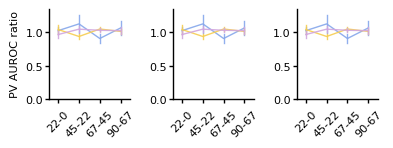

In [9]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[df_ratio.ori_pair != 0], 
                       x='ori_pair', y='acc_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(0, 4)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.35
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('PV AUROC ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_auroc_ratio_across_area_neighbor_dvall_PV_10wellmax_notnorm.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

## fig6ab alt: normed pv decoder

(6, 4)
p = 0.4345
(22, 4)
p = 0.8154
(18, 4)
p = 0.3032


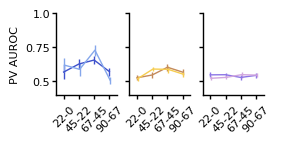

In [10]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

dir_pop_vec = r'C:\Users\ll357\Documents\inter\results\decoder_grat8\pop vec decoder jin2019 jeff'.replace('\\', '/')
xticklabels = ['0', '22.5', '45', '67.5', '90']
for i, iarea in enumerate(['V1', 'LM', 'LI']):

# pop_vec_decoder_neighbor_LI_dvall_PV_10wellmax_vecnorm
    res = sio.loadmat(os.path.join(dir_pop_vec, 
                                   f'pop_vec_decoder_neighbor_{iarea}_dvall_PV_10wellmax_vecnorm.mat'
                                   ))
    acc_250 = res['tmp_250'][:, 1:] # drop first col, where stim2_dist=0
    acc_750 = res['tmp_750'][:, 1:] # in 6k.mat, 750 is actually 6000
    print(acc_250.shape)

    ## one-sided paired t-test
    _, p = ttest_rel(acc_250[:, 0], acc_750[:, 0], alternative='two-sided')
    print(f'p = {np.round(p, 4)}')
    
    ax[i].errorbar(x=np.arange(acc_250.shape[1]),
                y=np.mean(acc_250, axis=0),
                yerr=np.std(acc_250, axis=0) / np.sqrt(acc_250.shape[0]),
                color=color_list_250[i], linewidth=1,
                label=f'{iarea} adapted')

    ax[i].errorbar(x=np.arange(acc_750.shape[1]) + 0.05,
                   
                y=np.mean(acc_750, axis=0),
                yerr=np.std(acc_750, axis=0) / np.sqrt(acc_750.shape[0]),
                color=color_list_noad[i], linewidth=1,
                label=f'{iarea} unadapted')
    
    xticklabels = ['22-0', '45-22', '67-45', '90-67']
    ax[i].set_xticks(range(acc_250.shape[1]), xticklabels, rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.25)
    ax[i].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[i].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[i].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[i].get_xlim()[1]
    ax[i].set_xlim(-0.5, xlim_upper+0.1)
    ax[i].spines['left'].set_linewidth(1) # set axis width
    ax[i].spines['bottom'].set_linewidth(1)
    # ax[i].legend(frameon=False, loc='upper left', fontsize=8);

ax[1].set_xlabel('', fontsize=8)
ax[0].set_ylabel('PV AUROC', fontsize=8)
plt.ylim(0.4, 1.0);
sns.despine();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_auroc_across_area_neighbor_dvall_PV_10wellmax_vecnorm.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [11]:
df_decode = pd.DataFrame(columns=['isi', 'ori_pair', 'acc', 'area', 'isess_area'])
for i, iarea in enumerate(['V1', 'LM', 'LI']):
    res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_neighbor_{iarea}_dvall_PV_10wellmax_vecnorm.mat'))

    for iisi, isi_val in enumerate([250, 750]): # in *6k.mat, 750 is actually 6000
        acc = res[f'tmp_{isi_val}'][:, 1:] # drop first col, where stim2_dist=0
        # print(acc.shape)

        for iori, ori_pair in enumerate(['22-0', '45-22', '67-45', '90-67']):
            for isess in range(acc.shape[0]):
                df_decode = df_decode = pd.concat([df_decode, 
                                                   pd.DataFrame({'isi': isi_val, 
                                                                'ori_pair': ori_pair, 
                                                                'acc': acc[isess, iori], 
                                                                'area': iarea, 
                                                                'isess_area': isess, # session index within area
                                                                }, index=[0])
                                                                ])
                                              
df_decode = df_decode.reset_index(drop=True)
# assert len(df_decode) == nsess * nisi * nori_pair

In [12]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
for df_prod in [df_decode[df_decode.area == 'V1'], 
                df_decode[df_decode.area == 'LM'], 
                df_decode[df_decode.area == 'LI']]:
    
    model = ols('acc ~ C(isi) + C(ori_pair) + C(isi):C(ori_pair)', data=df_prod).fit()
    print(sm.stats.anova_lm(model, typ=2))

                      sum_sq    df         F    PR(>F)
C(isi)              0.000330   1.0  0.027618  0.868848
C(ori_pair)         0.145002   3.0  4.046106  0.013285
C(isi):C(ori_pair)  0.040106   3.0  1.119119  0.352756
Residual            0.477831  40.0       NaN       NaN
                      sum_sq     df         F    PR(>F)
C(isi)              0.000108    1.0  0.009856  0.921036
C(ori_pair)         0.120219    3.0  3.643036  0.013971
C(isi):C(ori_pair)  0.026539    3.0  0.804211  0.493155
Residual            1.847986  168.0       NaN       NaN
                      sum_sq     df         F    PR(>F)
C(isi)              0.001147    1.0  0.197188  0.657706
C(ori_pair)         0.001705    3.0  0.097716  0.961170
C(isi):C(ori_pair)  0.011911    3.0  0.682454  0.564240
Residual            0.791203  136.0       NaN       NaN


In [13]:
## for sess, agg across ori-pair, then run one way anova across areas
print('one way anova across areas:')
df_decode_sess = df_decode.groupby(['isi', 'isess_area', 'area']).agg({'acc': 'mean'}).reset_index() # isess_area separates each sess
df_decode_sess = df_decode_sess[df_decode_sess.isi != 250] # only use control (unadapted)
print(stats.f_oneway(df_decode_sess[df_decode_sess.area == 'V1'].acc,
                df_decode_sess[df_decode_sess.area == 'LM'].acc,
                df_decode_sess[df_decode_sess.area == 'LI'].acc))

## compare acc vs chance: Wilcoxon Rank Sum test (aka Mann–Whitney U test)
print('')
print('compare perf vs chance:')
(stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'V1'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'V1'].acc), alternative='greater'), 
stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'LM'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'LM'].acc), alternative='greater'),
stats.mannwhitneyu(df_decode_sess[df_decode_sess.area == 'LI'].acc, 0.5*np.ones_like(df_decode_sess[df_decode_sess.area == 'LI'].acc), alternative='greater'))

one way anova across areas:
F_onewayResult(statistic=4.707580910778413, pvalue=0.014166017692904497)

compare perf vs chance:


(MannwhitneyuResult(statistic=36.0, pvalue=0.001389215055049515),
 MannwhitneyuResult(statistic=462.0, pvalue=1.821192032862591e-08),
 MannwhitneyuResult(statistic=270.0, pvalue=0.00013878546089248376))

In [14]:
df_ratio = pd.DataFrame(columns=['ori_pair', 'acc_ratio', 'area'])
for iarea, df_iarea in enumerate([df_decode[df_decode.area == 'V1'], 
                                df_decode[df_decode.area == 'LM'], 
                                df_decode[df_decode.area == 'LI']]):

    df_pivot = df_iarea.pivot_table(index=['ori_pair', 'isess_area'], 
                                                      columns='isi', 
                                                      values='acc').reset_index()
    df_pivot.columns = ['ori_pair', 'isess_area', 'acc_250', 'acc_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['ori_pair', 'isess_area', 
                                    'acc_250', 'acc_6000',
                                    'acc_ratio', 'area'])
    area_list = ['V1', 'LM', 'LI']
    for key, group in df_pivot.groupby(['ori_pair']):
        group['acc_250'] = (group['acc_250'].values)
        group['acc_6000'] = (group['acc_6000'].values)
        group['acc_ratio'] = group['acc_250'] / group['acc_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

model = ols('acc_ratio ~ C(area) + C(ori_pair) + C(area):C(ori_pair)', data=df_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                       sum_sq     df         F    PR(>F)
C(area)              0.001849    2.0  0.023699  0.976583
C(ori_pair)          0.087233    3.0  0.745415  0.526402
C(area):C(ori_pair)  0.444872    6.0  1.900749  0.083275
Residual             6.709461  172.0       NaN       NaN


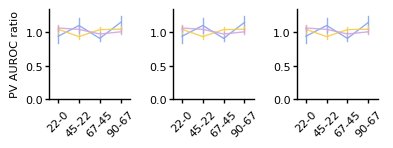

In [16]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[df_ratio.ori_pair != 0], 
                       x='ori_pair', y='acc_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(0, 4)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.35
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('PV AUROC ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_auroc_ratio_across_area_neighbor_dvall_PV_10wellmax_vecnorm.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')